# Global Sensitivity Analysis (Sobol-Saltelli sequence & Feature Scoring)

In [2]:
# load library

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statistics

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy)
from ema_workbench import load_results
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging
from ema_workbench import save_results

from SALib.analyze import sobol
from ema_workbench.em_framework.evaluators import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import BaseEvaluator
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation

## Running Sobol for Problem Formulation 2 & 3

In [12]:
# problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)

policies = [Policy("base case without any policies", **{i.name: 0 for i in dike_model.levers})]
problem = get_SALib_problem(dike_model.uncertainties)

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=5000, policies = policies, uncertainty_sampling=Samplers.SOBOL)

end = time.time()

print('Total run time:{} min'.format((end - start)/60))

# Save the results
save_results(sa_results, './results/sobol_results_problem2.tar.gz')

[MainProcess/INFO] pool started with 8 workers
/Users/nikhil/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 200000 scenarios * 1 policies * 1 model(s) = 200000 experiments


  0%|                                               | 0/200000 [00:00<?, ?it/s]

  0%|                                   | 1/200000 [00:05<300:42:50,  5.41s/it]

  0%|                                    | 4/200000 [00:05<59:07:47,  1.06s/it]

  0%|                                    | 9/200000 [00:05<21:58:29,  2.53it/s]

  0%|                                   | 11/200000 [00:05<17:02:42,  3.26it/s]

  0%|                                    | 17/200000 [00:06<9:04:10,  6.12it/s]

  0%|                                    | 22/200000 [00:06<6:22:12,  8.72it/s]

  0%|                                    | 25/200000 [00:06<5:23:51, 10.29it/s]

  0%

Total run time:383.3298923651377 min


[MainProcess/INFO] results saved successfully to /Users/nikhil/Documents/MSc Vakken/Q3/J1Q3 Advanced Simulation/EPA141A-labs/final assignment/EPA141A-labs/final assignment/results/sobol_results.tar.gz


## Plotting Results

In [28]:
def sobol_results(experiments, outcomes, problem, name):
    # Initialize list for valid plot data
    valid_keys = []
    valid_indices_list = []
    valid_err_list = []
    
    # Loop over outcomes to collect valid plot data
    for key in outcomes.keys():
        Si = sobol.analyze(problem, outcomes[key], calc_second_order=True, print_to_console=False)
        scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
        Si_df = pd.DataFrame(scores_filtered, index=problem["names"])
        
        # Check if all values in Si_df are zeros
        if Si_df.sum().sum() == 0:
            print(f"Skipping plot for {key} because all data is zeros.")
            continue
        
        indices = Si_df[["S1", "ST"]].sort_values(by="ST", ascending=False)
        err = Si_df[["S1_conf", "ST_conf"]].reindex(indices.index)
        
        # Store valid data
        valid_keys.append(key)
        valid_indices_list.append(indices)
        valid_err_list.append(err)
    
    # Initialize plot with only valid subplots
    fig, axes = plt.subplots(len(valid_keys), 1, figsize=(10, 8 * len(valid_keys)))
    if len(valid_keys) == 1:
        axes = [axes]  # Ensure axes is a list if there's only one subplot
    
    labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']  # Adjust the length if you have more than 10 plots
    
    # Loop over valid data to create subplots
    for plot_index, key in enumerate(valid_keys):
        sns.set_style("white")
    
        indices = valid_indices_list[plot_index]
        err = valid_err_list[plot_index]
        
        # Plot bar chart on the current subplot
        ax = axes[plot_index]
        indices.plot.bar(yerr=err.values.T, ax=ax)
        
        # Customize subplot
        ax.set_title(f'Global Sensitivity Analysis on {key}', fontweight='bold')
        ax.set_xlabel('Uncertainties')
        ax.set_ylabel('Total Expected Number of Deaths')
        ax.text(-0.1, 1.1, labels[plot_index], transform=ax.transAxes, size=20, weight='bold')  # Label the subplot
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'./images/Sensitivity_sobol_{name}_combined.png')
    plt.show()

Interpretation: A1_pfail and A3_pfail are the most dominant parameters to which the model is sensitive. The relatively small differences between the first-order effects and total-order effects suggest that most of the sensitivity is due to direct effects rather than due to interaction effects.\

A1_pfail = probability that the dike from dikering 1 will withstand the hydraulic load.\
A3_pfail = probability that the dike from dikering 3 will withstand the hydraulic load.

S2 is not readable :)

# Sobol Problem Formulation 2

[MainProcess/INFO] results loaded successfully from /Users/nikhil/Documents/MSc Vakken/Q3/J1Q3 Advanced Simulation/EPA141A-labs/final assignment/EPA141A-labs/final assignment/results/sobol_results_problem2.tar.gz
/Users/nikhil/anaconda3/lib/python3.11/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


Skipping plot for Dike Investment Costs because all data is zeros.
Skipping plot for RfR Investment Costs because all data is zeros.
Skipping plot for Evacuation Costs because all data is zeros.


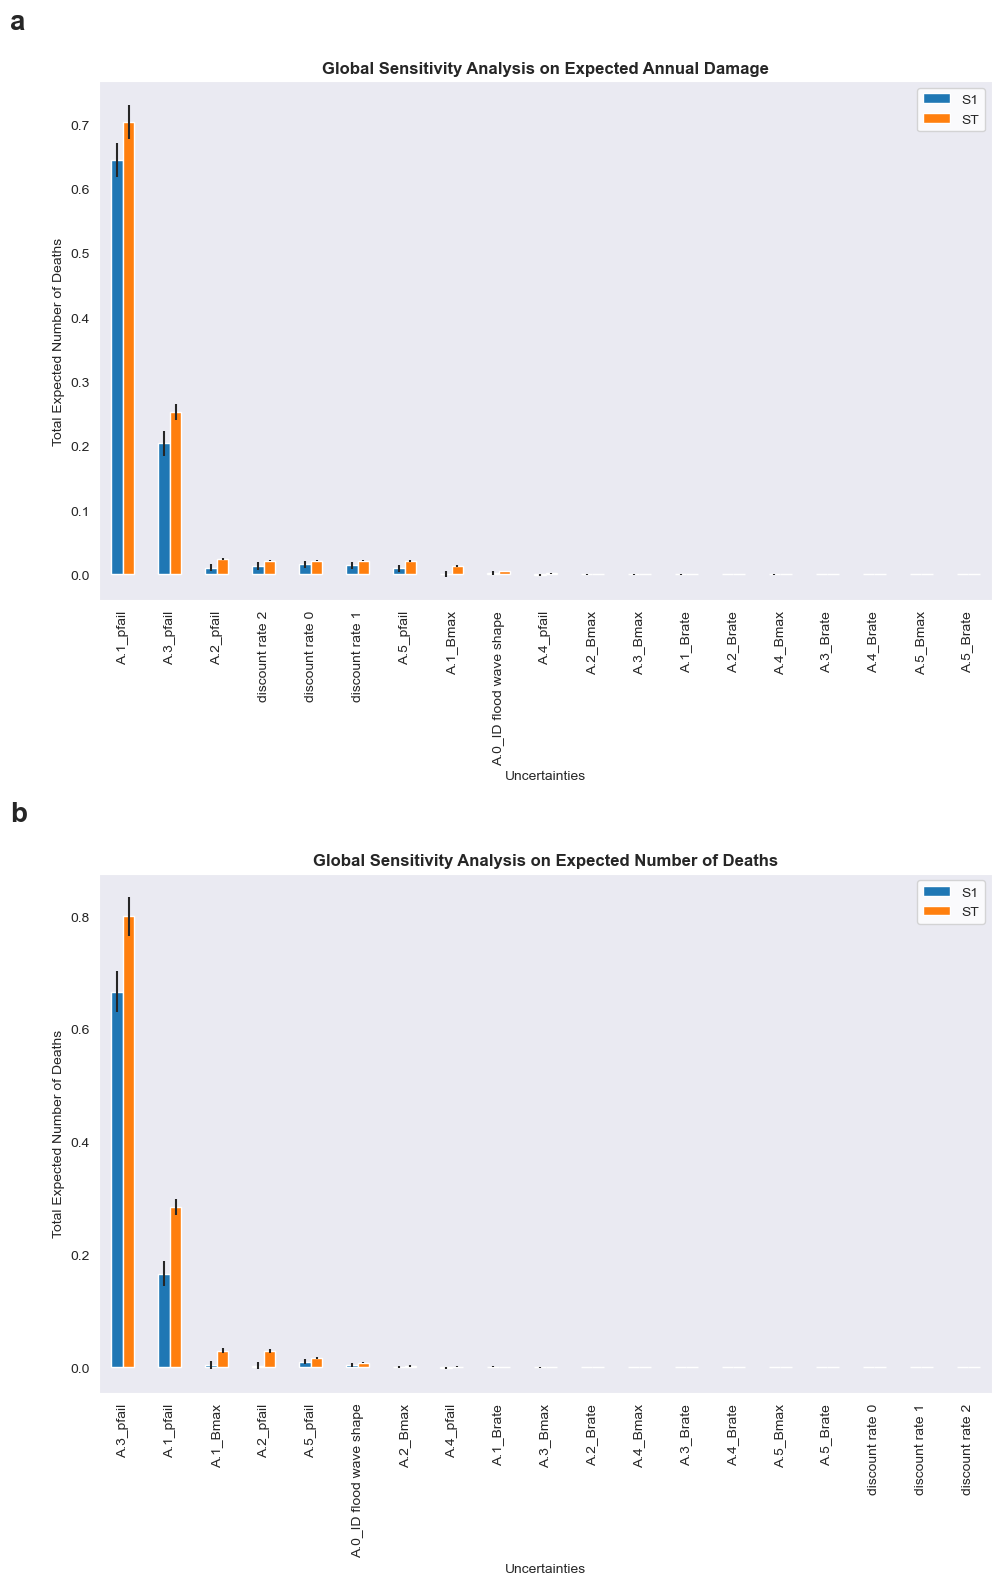

In [30]:
# Load results and define problem
experiments, outcomes = load_results("./results/sobol_results_problem2.tar.gz")
problem = get_SALib_problem(dike_model.uncertainties)
name = 'problem2'

sobol_results(experiments, outcomes, problem, name)

# Sobol Problem Formulation 3

[MainProcess/INFO] results loaded successfully from /Users/nikhil/Documents/MSc Vakken/Q3/J1Q3 Advanced Simulation/EPA141A-labs/final assignment/EPA141A-labs/final assignment/results/sobol_results_problem3.tar.gz
/Users/nikhil/anaconda3/lib/python3.11/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


Skipping plot for RfR Total Costs because all data is zeros.
Skipping plot for Expected Evacuation Costs because all data is zeros.


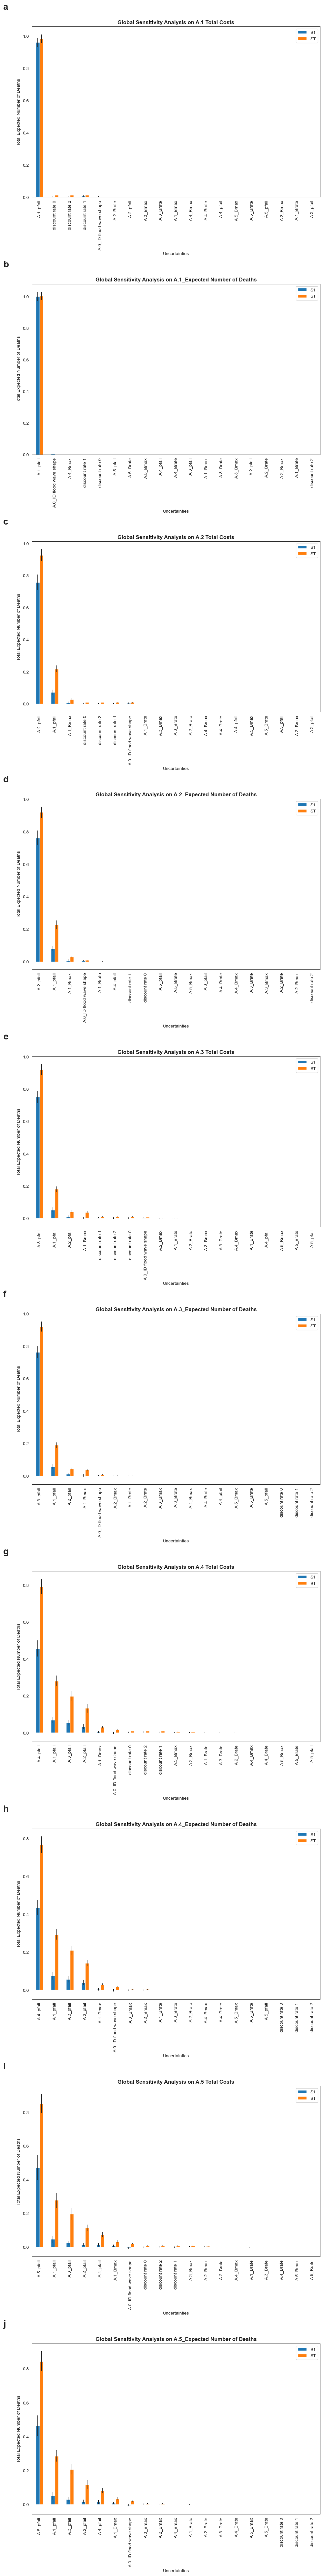

In [31]:
experiments, outcomes = load_results('./results/sobol_results_problem3.tar.gz')
problem = get_SALib_problem(dike_model.uncertainties)
name= 'problem3'

# Open Exploration: Uncertainty Analysis (Feature Scoring)

This analysis investigates how uncertainties in the Ijssel River simulation model can affect its outcomes. We use a technique called feature scoring to measure how closely each uncertainty is linked to specific results of the model.

We've chosen specific outputs from the model that are important to the province of Gelderland for this analysis. You can find more
details on these outputs in the report. This version uses simpler terms and breaks down the technical concepts into easier-to-understand parts. For a more detailed elaboration of the model results, please refer to the report. 

To ensure a comprehensive investigation, we have included outcomes from both problem formulation 2 and 3:

| Outcome Name | Problem Formulation |
| --- | --- |
| Expected Annual Damage | 2 |
| Expected Number of Deaths | 2 |
| A1 Total Costs | 2 |
| A1 Expected Number of Deaths | 3 |
| A2 Total Costs | 3 |
| A2 Expected Number of Deaths | 3 |
| A3 Total Costs | 3 |
| A3 Expected Number of Deaths | 3 |
| A4 Total Costs | 3 |
| A4 Expected Number of Deaths | 3 |
| A5 Total Costs | 3 |
| A5 Expected Number of Deaths | 3 | 

In [33]:
from ema_workbench.analysis import feature_scoring
def fs_plot(experiments, outcomes, name):
    
    x = experiments
    y = outcomes
    
    fs = feature_scoring.get_feature_scores_all(x, y)
    fs
    # Remove rows that only have zeros
    fs = fs.loc[~(fs== 0).all(axis=1)]
    fs = fs.loc[:, (fs != 0).any(axis=0)]
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(fs, cmap="viridis", annot=True)
    
    #Graph setup
    plt.title('Feature Scoring for all the Uncertainties')
    plt.ylabel('Uncertainties')
    plt.xlabel('Outcomes of Interest')
    plt.savefig(f'./images/Sensitivity_Feature_Scoring_{name}.png')
    plt.show()

### Feature Scoring Problem Forumualtion 2

[MainProcess/INFO] results loaded successfully from /Users/nikhil/Documents/MSc Vakken/Q3/J1Q3 Advanced Simulation/EPA141A-labs/final assignment/EPA141A-labs/final assignment/results/sobol_results_problem2.tar.gz


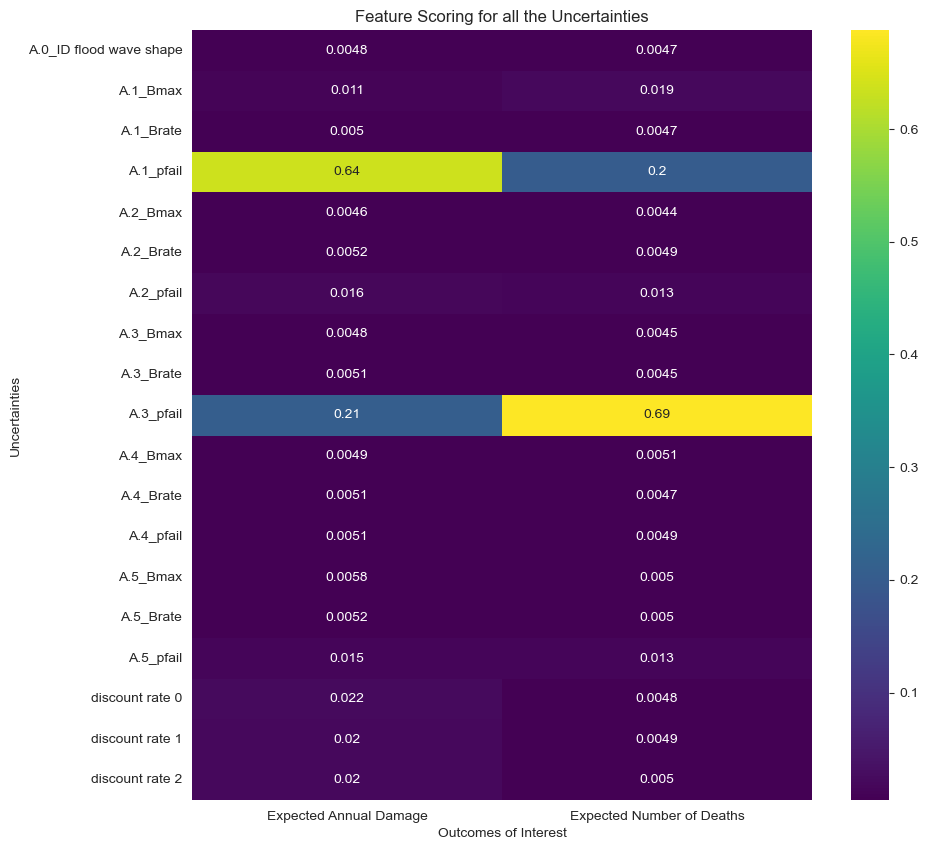

In [34]:
sa_results_pf2 = load_results('./results/sobol_results_problem2.tar.gz')
experiments, outcomes = sa_results_pf2
name = 'problem2'
fs_plot(experiments,outcomes, name)

### Feature Scoring Problem Forumation 3

[MainProcess/INFO] results loaded successfully from /Users/nikhil/Documents/MSc Vakken/Q3/J1Q3 Advanced Simulation/EPA141A-labs/final assignment/EPA141A-labs/final assignment/results/sobol_results_problem3.tar.gz


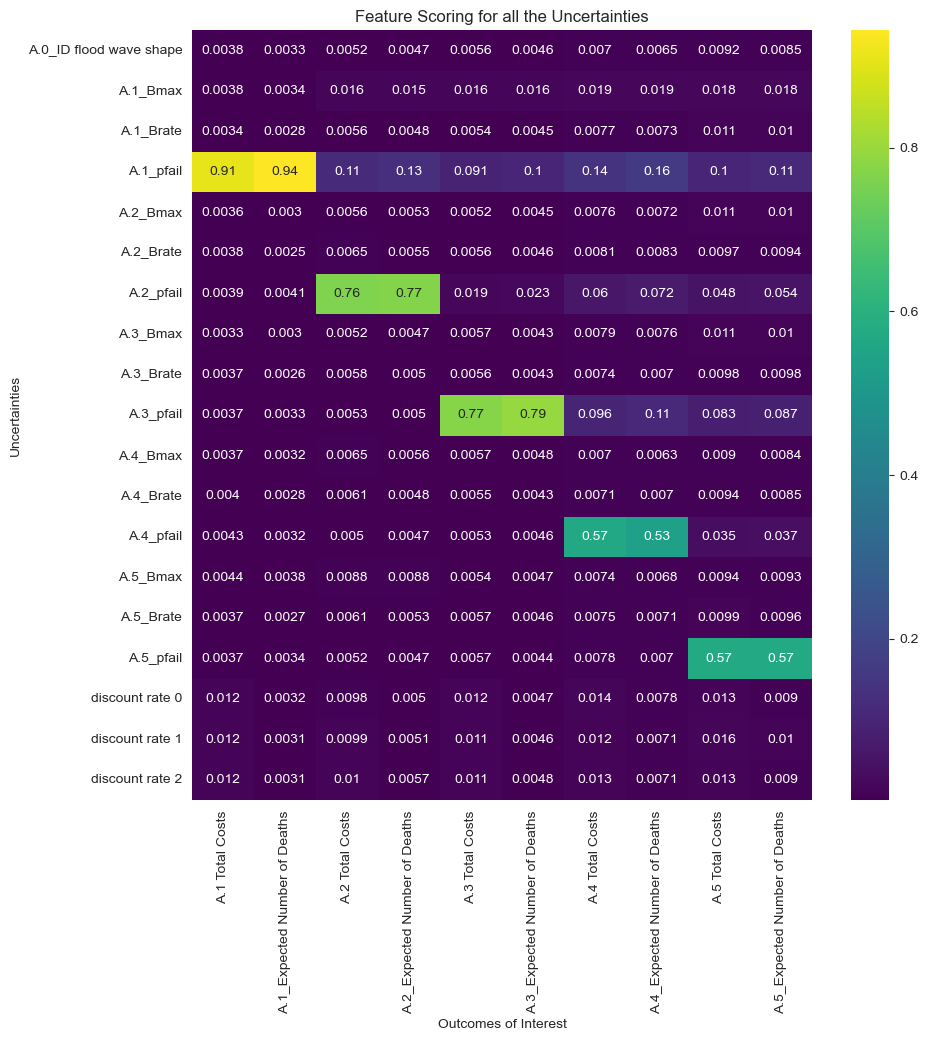

In [35]:
sa_results_pf3 = load_results('./results/sobol_results_problem3.tar.gz')
experiments, outcomes = sa_results_pf3
name = 'problem3'
fs_plot(experiments,outcomes, name)